In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
pd.set_option("display.max_columns",101)

In [2]:
def calc_game_of_season(df):
    '''Calculates the game of the season each team is on'''
    df = df.sort_values(by=['Team', 'Season', 'Opponent']).reset_index(drop=True)
    curr_team = df['Team'][0]
    curr_opp = df['Opponent'][0]
    curr_game = 0
    curr_year = df['Season'][0]
    df['game_of_season'] = 0
    for idx, row in df.iterrows():
        if curr_team == row['Team']:
            if curr_year == row['Season']:
                if curr_opp == row['Opponent']:
                    df.loc[idx,'game_of_season'] = curr_game
                elif curr_opp != row['Opponent']: 
                    curr_game += 1
                    df.loc[idx, 'game_of_season'] = curr_game
            elif curr_year != row['Season']:
                curr_game = 0
        elif curr_team != row['Team']:
            curr_game = 0
        curr_team = row['Team']
        curr_opp = row['Opponent']
        curr_year = row['Season']

    for idx, row in df.iterrows():
        if idx != 0 and idx != df.shape[0] - 1:
            if (row['game_of_season'] == 0) and (df.loc[idx + 1, 'game_of_season']) != 0:
                df.loc[idx, 'game_of_season'] = df.loc[idx + 1, 'game_of_season']           
    return df

In [3]:
def labeling(df, old_columns, new_columns, label_names, fit_list):
    '''will do labeling for all of df
    
    Params: 
        df: dataframe
        old_columns (list): list of the columns that need labels
        new_columns (list): list of new column names
        label_names (list): list of labels for label encoder
        fit (list): true if fit_transform needed else it is the index of the label_name
    
    ** note all lists must be equal lengths 
    '''
    
    for i in range(len(old_columns)):
        name = label_names[i]
        if fit_list[i] == False:
            label_names[i] = LabelEncoder()
            df[new_columns[i]] = label_names[i].fit_transform(df[old_columns[i]])
        else:
            df[new_columns[i]] = label_names[fit_list[i]].transform(df[old_columns[i]])
    return df

In [4]:
def label_encoder(df):
    '''Creates labels for player_name, team, and opponent
    
    Params:
        df (DataFrame): pandas dataframe
    
    Returns:
        df (DataFrame): dataframe with new columns of numerical labels
    '''
    player = LabelEncoder()
    df['Player_ID'] = player.fit_transform(df['Player_Name'])
    team = LabelEncoder()
    df['Team_ID'] = team.fit_transform(df['Team'])
    opp = LabelEncoder()
    df['Opp_ID'] = opp.fit_transform(df['Opponent'])
    return df

In [5]:
def calculate_fantasy_points(df):
    df['Points'] = (df['Total_Yards']/10) + (df['TDs'] * 6) + (df['Fumbles'] * (-2))
    return df

In [6]:
def prev_year_game_points(df):
    group = df.groupby(['Player_ID', 'Team_ID', 'Season', 'Opp_ID']).mean().reset_index()[['Player_ID', 'Team_ID', 'Opp_ID', 'Season', 'Points']].rename(columns={'Points': 'prev_year_game'})
    group['Season'] += 1
    group.drop(group[group['Season'] == 2018].index, inplace=True)
    df = df.merge(group, on=['Player_ID', 'Team_ID', 'Season', 'Opp_ID'], how='left')
    df.fillna(0, inplace=True)
    df['no_prev_year_game'] = df['prev_year_game'].apply(lambda x: 1 if x == 0 else 0)
    return df

In [7]:
def prev_year_total_points(df):
    group = df.groupby(['Player_ID', 'Season']).sum().reset_index()[['Player_ID', 'Season', 'Points']].rename(columns={'Points':'prev_year_total'})
    group['Season'] += 1
    group.drop(group[group['Season'] == 2018].index, inplace=True)
    df = df.merge(group, on=['Player_ID', 'Season'], how='left')
    df.fillna(0, inplace=True)
    df['no_prev_year'] = df['prev_year_total'].apply(lambda x: 1 if x == 0 else 0)
    return df

In [8]:
def prev_game_points(df):
    group = df.groupby(['Player_ID', 'Season', 'game_of_season']).sum().reset_index().rename(columns={'Points': 'prev_game_points'})[['Player_ID', 'Season', 'game_of_season', 'prev_game_points']]
    group['game_of_season'] += 1
    group.drop(group[group['game_of_season'] == 16].index, inplace=True)
    df = df.merge(group, on=['Player_ID', 'Season', 'game_of_season'], how='left')
    df.fillna(0, inplace=True)
    df['first_game_of_season'] = df['game_of_season'].apply(lambda x: 1 if x == 0 else 0)
    return df

In [9]:
def season_total_so_far(df):
    cur_df = df[['Player_ID', 'Season', 'game_of_season']]
    for i in range(np.max(df['game_of_season'].values)):
        up_to = df.copy()
        up_to.drop_duplicates(keep='last', inplace=True)
        up_to.drop(up_to[up_to['game_of_season'] >= i].index, inplace=True)
        up_to = up_to.groupby(['Player_ID', 'Season']).sum().reset_index()
        up_to['game_of_season'] = i
        up_to = up_to.drop_duplicates(keep='last')
        up_to = up_to.rename(columns={'Points':'cur_season_total'})[['Player_ID', 'Season', 'game_of_season', 'cur_season_total']]
        cur_df = pd.concat([cur_df, up_to])
    df = df.merge(cur_df, how='left', on=['Player_ID', 'Season', 'game_of_season'])
    return df

In [10]:
def cleaning(df, cols_wanted, groupby_cols):
    college = LabelEncoder()
    df['College_ID'] = college.fit_transform(df['College'])
    position = LabelEncoder()
    df['Position_ID'] = position.fit_transform(df['Position'])
    df = calc_game_of_season(df)
    df['Home'] = df.apply(lambda x: 1 if x.home == x.Team else 0, axis=1)
    df = label_encoder(df)
    df.drop_duplicates(subset=['Player_ID', 'Season', 'game_of_season'], inplace=True, keep='last')
    df = df.groupby(groupby_cols).mean()
    df = calculate_fantasy_points(df)
    df.reset_index(inplace=True)
    df = season_total_so_far(df)
    df = prev_year_game_points(df)
    df = prev_year_total_points(df)
    df = prev_game_points(df)
    df = df[cols_wanted]
    df.drop(df[df['Season'] == 2009].index, inplace=True)
    df.drop(['Total_Yards', 'TDs', 'Fumbles'], axis=1, inplace=True)
    for col in df.columns:
        if col.endswith('_ID'):
            df[col] = df[col].astype('category')
    train_df = df.drop(df[df['Season'] == 2017].index, axis=0)
    test_df = df.drop(df[df['Season'] != 2017].index, axis=0)
    return train_df, test_df

In [11]:
game_2009 = pd.read_csv('season_games/games_2009.csv')
game_2010 = pd.read_csv('season_games/games_2010.csv')
game_2011 = pd.read_csv('season_games/games_2011.csv')
game_2012 = pd.read_csv('season_games/games_2012.csv')
game_2013 = pd.read_csv('season_games/games_2013.csv')
game_2014 = pd.read_csv('season_games/games_2014.csv')
game_2015 = pd.read_csv('season_games/games_2015.csv')
game_2016 = pd.read_csv('season_games/games_2016.csv')
game_2017 = pd.read_csv('season_games/games_2017.csv')

In [12]:
all_games = pd.concat([game_2009, game_2010, 
                       game_2011, game_2012, 
                       game_2013, game_2014,
                       game_2015, game_2016], axis=0)

all_games.index = all_games['GameID']

In [132]:
injury = pd.read_csv('../../Fantasy-2008-2017/Injury.2008-2017.csv')

injury = injury.rename(columns={'Week':'game_of_season'})[['Name', 'Season', 'Team', 'Opponent', 'BodyPart', 'Status', 'Practice', 'PracticeDescription', 'InjuryID']]

injury['Player_Name'] = injury['Name'].apply(lambda x: x.split(' ')[0][0] + '.' + x.split(' ')[-1])

In [137]:
injury

,Name,Season,Team,Opponent,BodyPart,Status,Practice,PracticeDescription,InjuryID,Player_Name
0,Jim Dray,2011,ARI,CAR,Pectoral,Out,None,Did Not Participate In Practice,129,J.Dray
1,John Skelton,2011,ARI,CAR,Ankle,Questionable,Full,Full Participation in Practice,130,J.Skelton
2,Michael Adams,2011,ARI,CAR,Knee,Questionable,Limited,Limited Participation in Practice,131,M.Adams
3,Rob Housler,2011,ARI,CAR,Groin,Probable,Full,Full Participation in Practice,132,R.Housler
4,Korey Lindsey,2011,ARI,CAR,Illness,Probable,Full,Full Participation in Practice,133,K.Lindsey
5,DeMarco Sampson,2011,ARI,CAR,Hamstring,Probable,Full,Full Participation in Practice,134,D.Sampson
6,Alfonso Smith,2011,ARI,CAR,Hamstring,Probable,Full,Full Participation in Practice,135,A.Smith
7,Adrian Wilson,2011,ARI,CAR,Biceps,Probable,Full,Full Participation in Practice,136,A.Wilson
8,Corey Peters,2011,ATL,CHI,Knee,Out,None,Did Not Participate In Practice,70,C.Peters
9,Todd McClure,2011,ATL,CHI,Knee,Out,Out,Out (Definitely Will Not Play),71,T.McClure


In [13]:
game_player_stats_rush = pd.read_csv('game_player_stats/game_rushing_df.csv')

game_player_stats_rush.drop('TD_to_Fumbles', axis=1, inplace=True)

In [14]:
players = pd.read_csv('../../Fantasy-2008-2017/Player.2008-2017.csv')

players = players[['ShortName', 'Team', 'Position', 'HeightFeet', 'HeightInches', 'Weight', 'Age', 'College', 'Experience', 'CollegeDraftYear', 'CollegeDraftPick']]

players = players.drop(players[players['CollegeDraftYear'] == 2018].index)

players = players.rename(columns={'ShortName':'Player_Name'})

players['Height'] = (players['HeightFeet']) + (players['HeightInches'] / 12)
players.drop(['HeightFeet', 'HeightInches'], axis=1, inplace=True)

In [15]:
list_of_players_dfs = []

for i in range(0,9):
    player_year = players.copy()
    player_year.drop_duplicates(inplace=True)
    player_year['Season'] = i + 2009
    if i < 8:
        player_year['Age'] -= (-i+8)
        player_year['Experience'] -= (-i+8)
    list_of_players_dfs.append(player_year)

players = pd.concat(list_of_players_dfs).reset_index()

players.drop(players[players['Experience'] < 0]. index, inplace=True)

players.loc[18577, 'Team'] = 'TEN'

players.drop(players[(players['Player_Name'] == 'C.Johnson') & (players['CollegeDraftYear'] == 2007) & (players['Position'] == 'DE') & (players['Season'] != 2009)].index, inplace=True)

<b> importing offensive and defensive rankings

In [16]:
off_df = pd.read_csv('offensive_rankings-2009-2017.csv')
def_df = pd.read_csv('defensive_rankings-2009-2017.csv')
off_df.drop('Unnamed: 0', axis=1, inplace=True)
def_df.drop('Unnamed: 0', axis=1, inplace=True)
off_df = off_df.rename(columns={'Rank': 'Offensive_Rank', 'Name': 'Offensive_Team'})
def_df = def_df.rename(columns={'Rank': 'Defensive_Rank', 'Name': 'Defensive_Team'})

In [110]:
def_rush = pd.read_csv('def-rush.csv')

In [115]:
def_rush.columns

Index(['Unnamed: 0', 'Tm', 'Att', 'Yds', 'TD', 'Season', 'Rank', 'Team'], dtype='object')

In [117]:
def_df = def_df.merge(def_rush[['Team', 'Season', 'Att', 'Yds', 'TD']].rename(columns={'Att': 'Def_Allowed_Att', 'Yds': 'Def_Allowed_Yds', 'TD':'Def_Allowed_TD'}), on=['Team', 'Season'], )

In [120]:
merged = pd.merge(game_player_stats_rush, pd.concat([all_games, game_2017]).reset_index(), on='GameID')

merged = merged.merge(off_df[['Team', 'Offensive_Rank','Season']], 
                      on=['Season', 'Team']).merge(def_df[['Team','Defensive_Rank', 
                                                           'Season', 'Def_Allowed_Att',
                                                           'Def_Allowed_Yds', 'Def_Allowed_TD']].rename(columns={'Team': 'Opponent'}), 
                                                   on=['Season', 'Opponent'])

In [131]:
merged.shape

(3305, 59)

In [122]:
merged = merged.merge(players, on=['Player_Name', 'Team', 'Season'], how='left')

<b> fill na then create columns saying data is missing

In [123]:
merged.dropna(inplace=True)

merged['Weight'] = merged['Weight'].fillna(np.mean(merged['Weight']))
merged['NoWeight'] = merged['Weight'].apply(lambda x: 1 if x==np.mean(merged['Weight']) else 0)

merged['Position'] = merged['Position'].fillna('None')
merged['NoPosition'] = merged['Position'].apply(lambda x: 1 if x=='None' else 0)

merged['CollegeDraftYear'] = merged['CollegeDraftYear'].fillna(np.mean(merged['CollegeDraftYear']))
merged['NoDraftYear'] = merged['CollegeDraftYear'].apply(lambda x: 1 if x==np.mean(merged['CollegeDraftYear']) else 0)

merged['CollegeDraftPick'] = merged['CollegeDraftPick'].fillna(np.mean(merged['CollegeDraftPick']))
merged['NoDraftPick'] = merged['CollegeDraftPick'].apply(lambda x: 1 if x==np.mean(merged['CollegeDraftPick']) else 0)

merged['Height'] = merged['Height'].fillna(np.mean(merged['Height']))
merged['NoHeight'] = merged['Height'].apply(lambda x: 1 if x==np.mean(merged['Height']) else 0)

merged['Age'] = merged['Age'].fillna(np.mean(merged['Age']))
merged['NoAge'] = merged['Age'].apply(lambda x: 1 if x==np.mean(merged['Age']) else 0)

merged = merged.sort_values(['Team','date'])

merged['College'] = merged['College'].fillna('None')

In [126]:
train_df, test_df = cleaning(merged, ['Team_ID', 'Opp_ID', 'Player_ID', 
                                      'Total_Yards', 'TDs', 'Fumbles', 
                                      'Home', 'Season', 'game_of_season', 
                                      'prev_year_game', 'no_prev_year_game',
                                      'no_prev_year', 'prev_year_total', 
                                      'prev_game_points', 'first_game_of_season', 
                                      'Offensive_Rank', 'Defensive_Rank',
                                      'Points', 'Weight', 'Age', 
                                      'College_ID', 'Experience', 'CollegeDraftYear', 
                                      'CollegeDraftPick', 'Height', 'NoWeight', 
                                      'NoPosition', 'NoDraftYear', 'NoDraftPick', 
                                      'NoHeight', 'NoAge', 'Position_ID', 'cur_season_total',
                                      'Def_Allowed_Att','Def_Allowed_Yds', 'Def_Allowed_TD'], 
                                ['Player_ID', 'Team_ID', 'Opp_ID', 'Season', 'Home'])

In [33]:
train_df, test_df = cleaning(merged, ['Team_ID', 'Opp_ID', 'Player_ID', 
                                      'Total_Yards', 'TDs', 'Fumbles', 
                                      'Home', 'Season', 'game_of_season', 
                                      'prev_year_game', 'no_prev_year_game',
                                      'no_prev_year', 'prev_year_total', 
                                      'prev_game_points', 
                                      'Offensive_Rank', 'Defensive_Rank',
                                      'Points', 'Weight', 'Age', 'College_ID', 
                                      'Experience', 'CollegeDraftYear', 
                                      'CollegeDraftPick', 'Height', 
                                      'Position_ID', 'cur_season_total'], 
                                ['Player_ID', 'Team_ID', 'Opp_ID', 'Season', 'Home'])

<b> feature engineering: previous games points

In [127]:
rf = RandomForestRegressor()
rf.fit(train_df.drop('Points', axis=1), train_df['Points'])

rf.score(test_df.drop('Points', axis=1), test_df['Points'])

0.082988530961418783

In [128]:
rf.score(train_df.drop('Points', axis=1), train_df['Points'])

0.94859286394294773

In [129]:
mse = []
for item in list(zip(rf.predict(test_df.drop('Points', axis=1)), test_df['Points'])):
    mse.append((item[0] - item[1])**2)
np.mean(mse)

25.878770716510907

In [130]:
sorted(list(zip(rf.feature_importances_, train_df.drop('Points', axis=1).columns)))

[(0.0, 'NoAge'),
 (0.0, 'NoDraftPick'),
 (0.0, 'NoDraftYear'),
 (0.0, 'NoHeight'),
 (0.0, 'NoPosition'),
 (0.0, 'NoWeight'),
 (0.00091254039525421151, 'first_game_of_season'),
 (0.0020760740058019069, 'no_prev_year'),
 (0.003609190340680244, 'no_prev_year_game'),
 (0.011201431254747988, 'Season'),
 (0.012761814939006341, 'Home'),
 (0.01473210507617532, 'Height'),
 (0.016512599010333508, 'Experience'),
 (0.01834927162700712, 'Player_ID'),
 (0.022673041890757285, 'College_ID'),
 (0.024974104870013378, 'cur_season_total'),
 (0.027004120271566172, 'prev_year_game'),
 (0.028376518015088503, 'CollegeDraftYear'),
 (0.02900364908234963, 'Age'),
 (0.031104444691457445, 'CollegeDraftPick'),
 (0.03686001905089837, 'Opp_ID'),
 (0.037148360441326314, 'Position_ID'),
 (0.038442654149718501, 'Weight'),
 (0.038696813976018415, 'Team_ID'),
 (0.040101095027039423, 'game_of_season'),
 (0.041472908024486263, 'Offensive_Rank'),
 (0.065761484160607744, 'Def_Allowed_TD'),
 (0.068095971653807763, 'Def_Allowed

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [57]:
gb = GradientBoostingRegressor()

In [58]:
gb.fit(train_df.drop('Points', axis=1), train_df['Points'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [59]:
gb.score(test_df.drop('Points', axis=1), test_df['Points'])

0.1615399957914776

In [46]:
gb.score(train_df.drop('Points', axis=1), train_df['Points'])

0.28304412422951553

In [82]:
def_rush_2009 = pd.read_csv('def-rush.csv')

def_rush_2009['Season'] = 2010
def_rush_2009['Rank'] = def_rush_2009.index
def_rush_2009.dropna(inplace=True)
def_rush_2009['Team'] = def_rush_2009['Tm'].apply(lambda x: teams[x])

In [31]:
mse = []
for item in list(zip(gb.predict(test_df.drop('Points', axis=1)), test_df['Points'])):
    mse.append((item[0] - item[1])**2)
np.mean(mse)

21.540413623241371

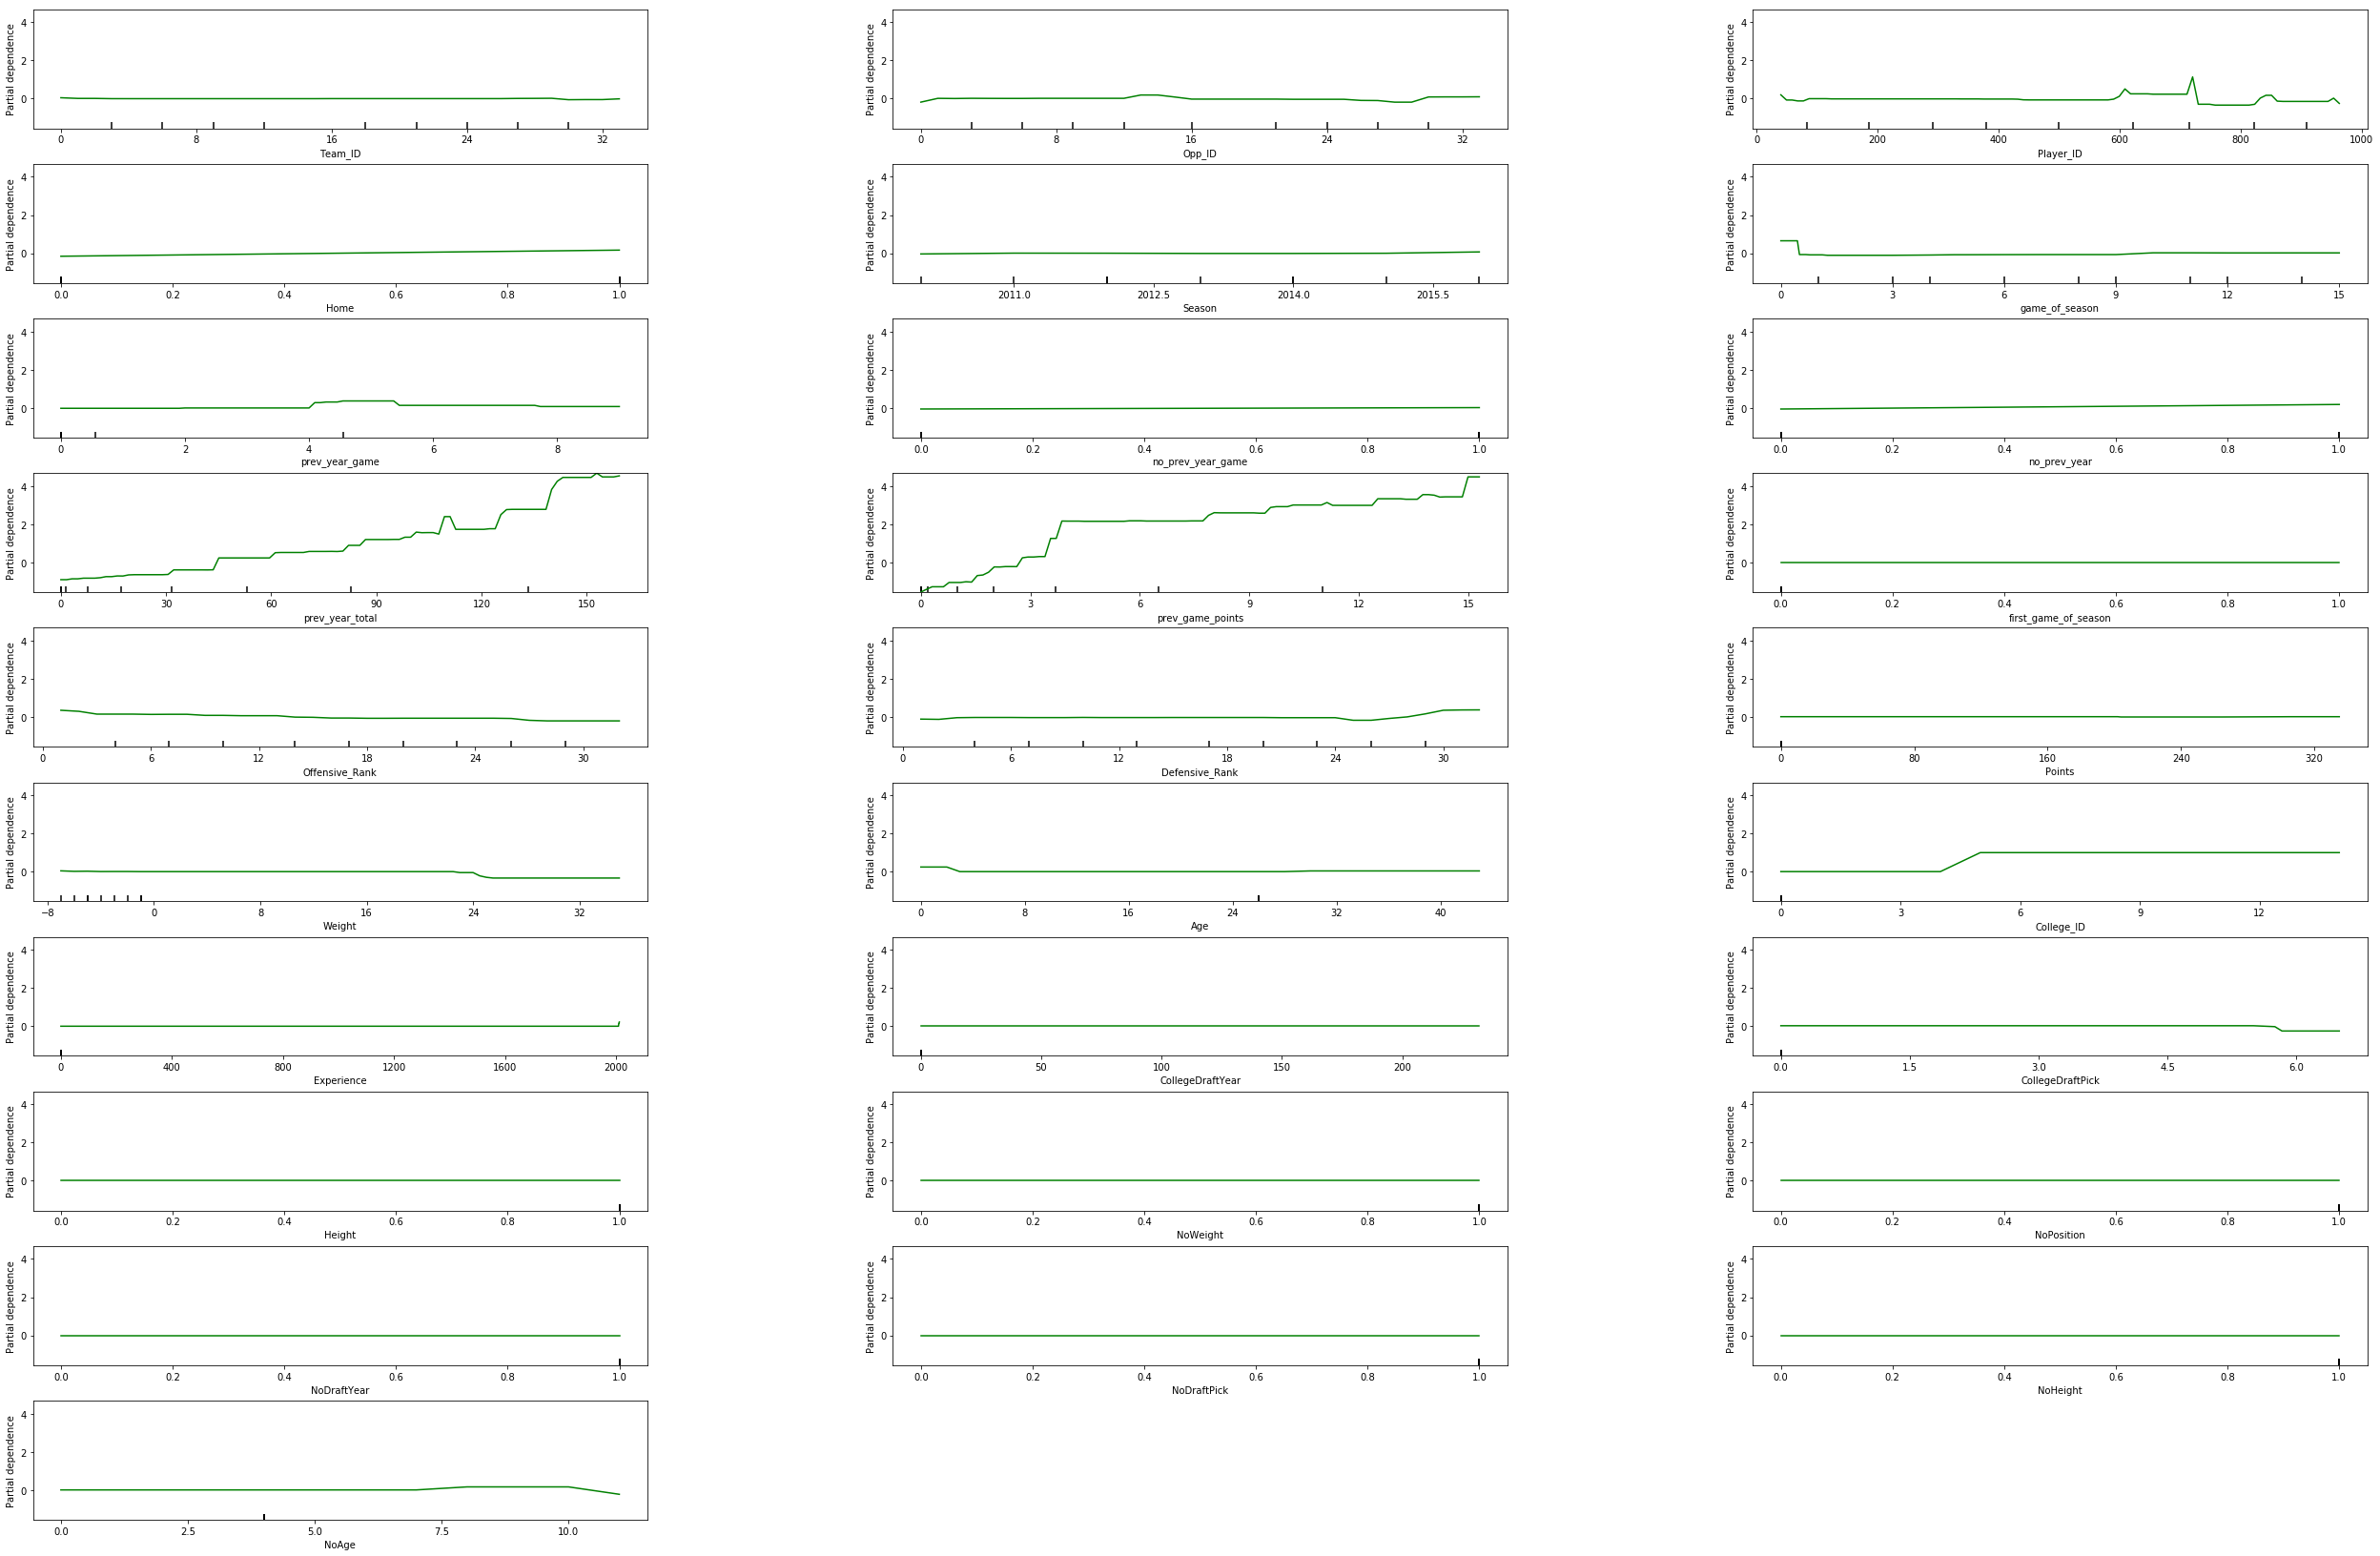

In [172]:
names = train_df.columns
%matplotlib inline
fig, axs = plot_partial_dependence(gb, train_df.drop('Points', axis=1),
                                   feature_names=names, features=list(range(0,28)),
                                   n_jobs=3, grid_resolution=100,figsize=(40,40))

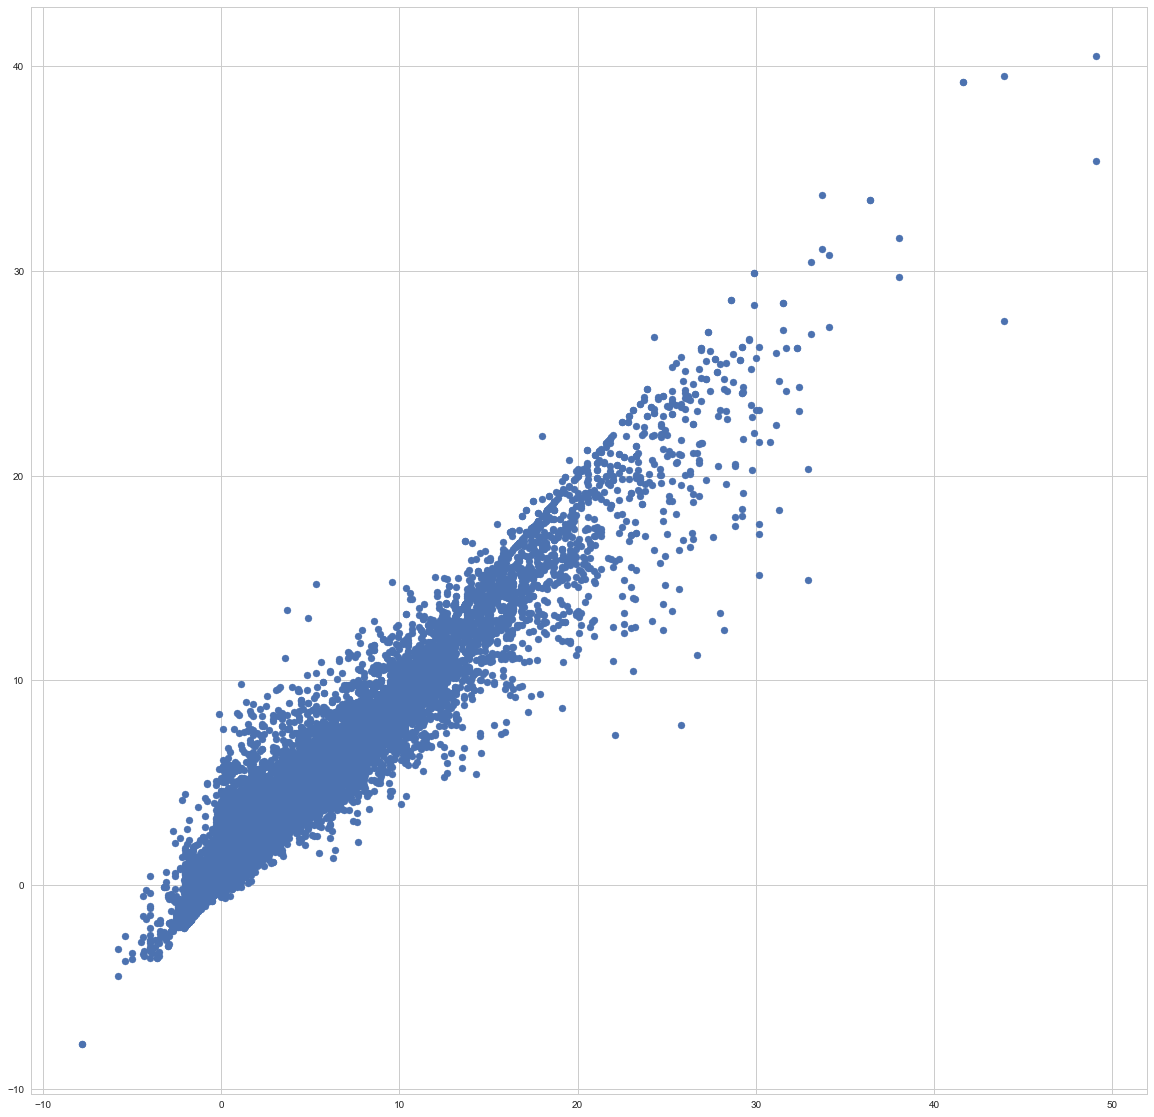

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(train_df['Points'], rf.predict(train_df.drop(['Points'], axis=1)))

In [63]:
teams = {'Indianapolis Colts': 'IND',
         'Tennessee Titans': 'TEN',
         'New England Patriots': 'NE',
         'New Orleans Saints': 'NO',
         'Houston Texans': 'HOU',
         'Arizona Cardinals': 'ARI',
         'San Diego Chargers': 'SD',
         'Atlanta Falcons': 'ATL',
         'Cincinnati Bengals': 'CIN',
         'Cleveland Browns': 'CLE',
         'New York Jets': 'NYJ',
         'New York Giants': 'NYG',
         'Carolina Panthers': 'CAR',
         'Tampa Bay Buccaneers': 'TB',
         'Dallas Cowboys': 'DAL',
         'Denver Broncos': 'DEN',
         'Miami Dolphins': 'MIA',
         'Minnesota Vikings': 'MIN',
         'Chicago Bears': 'CHI',
         'Baltimore Ravens': 'BAL',
         'Philadelphia Eagles': 'PHI',
         'San Francisco 49ers': 'SF',
         'Seattle Seahawks': 'SEA',
         'Detroit Lions': 'DET',
         'Jacksonville Jaguars': 'JAC',
         'St. Louis Rams': 'STL',
         'Kansas City Chiefs': 'KC',
         'Buffalo Bills': 'BUF',
         'Washington Redskins': 'WAS',
         'Oakland Raiders': 'OAK',
         'Pittsburgh Steelers': 'PIT',
         'Green Bay Packers': 'GB',
         'Los Angeles Chargers': 'LAC',
         'Los Angeles Rams': 'LA'}

<b> need to look at trends in data over time <br>
** data is overfit to the earlier years

In [127]:
all_years = pd.concat([train_df, test_df])

In [137]:
year_2010 = all_years[all_years['Season'] == 2010]
year_2017 = all_years[all_years['Season'] == 2017]

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2010.0, right=2010.0
  'left=%s, right=%s') % (left, right))
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=2010.0, top=2010.0
  'bottom=%s, top=%s') % (bottom, top))


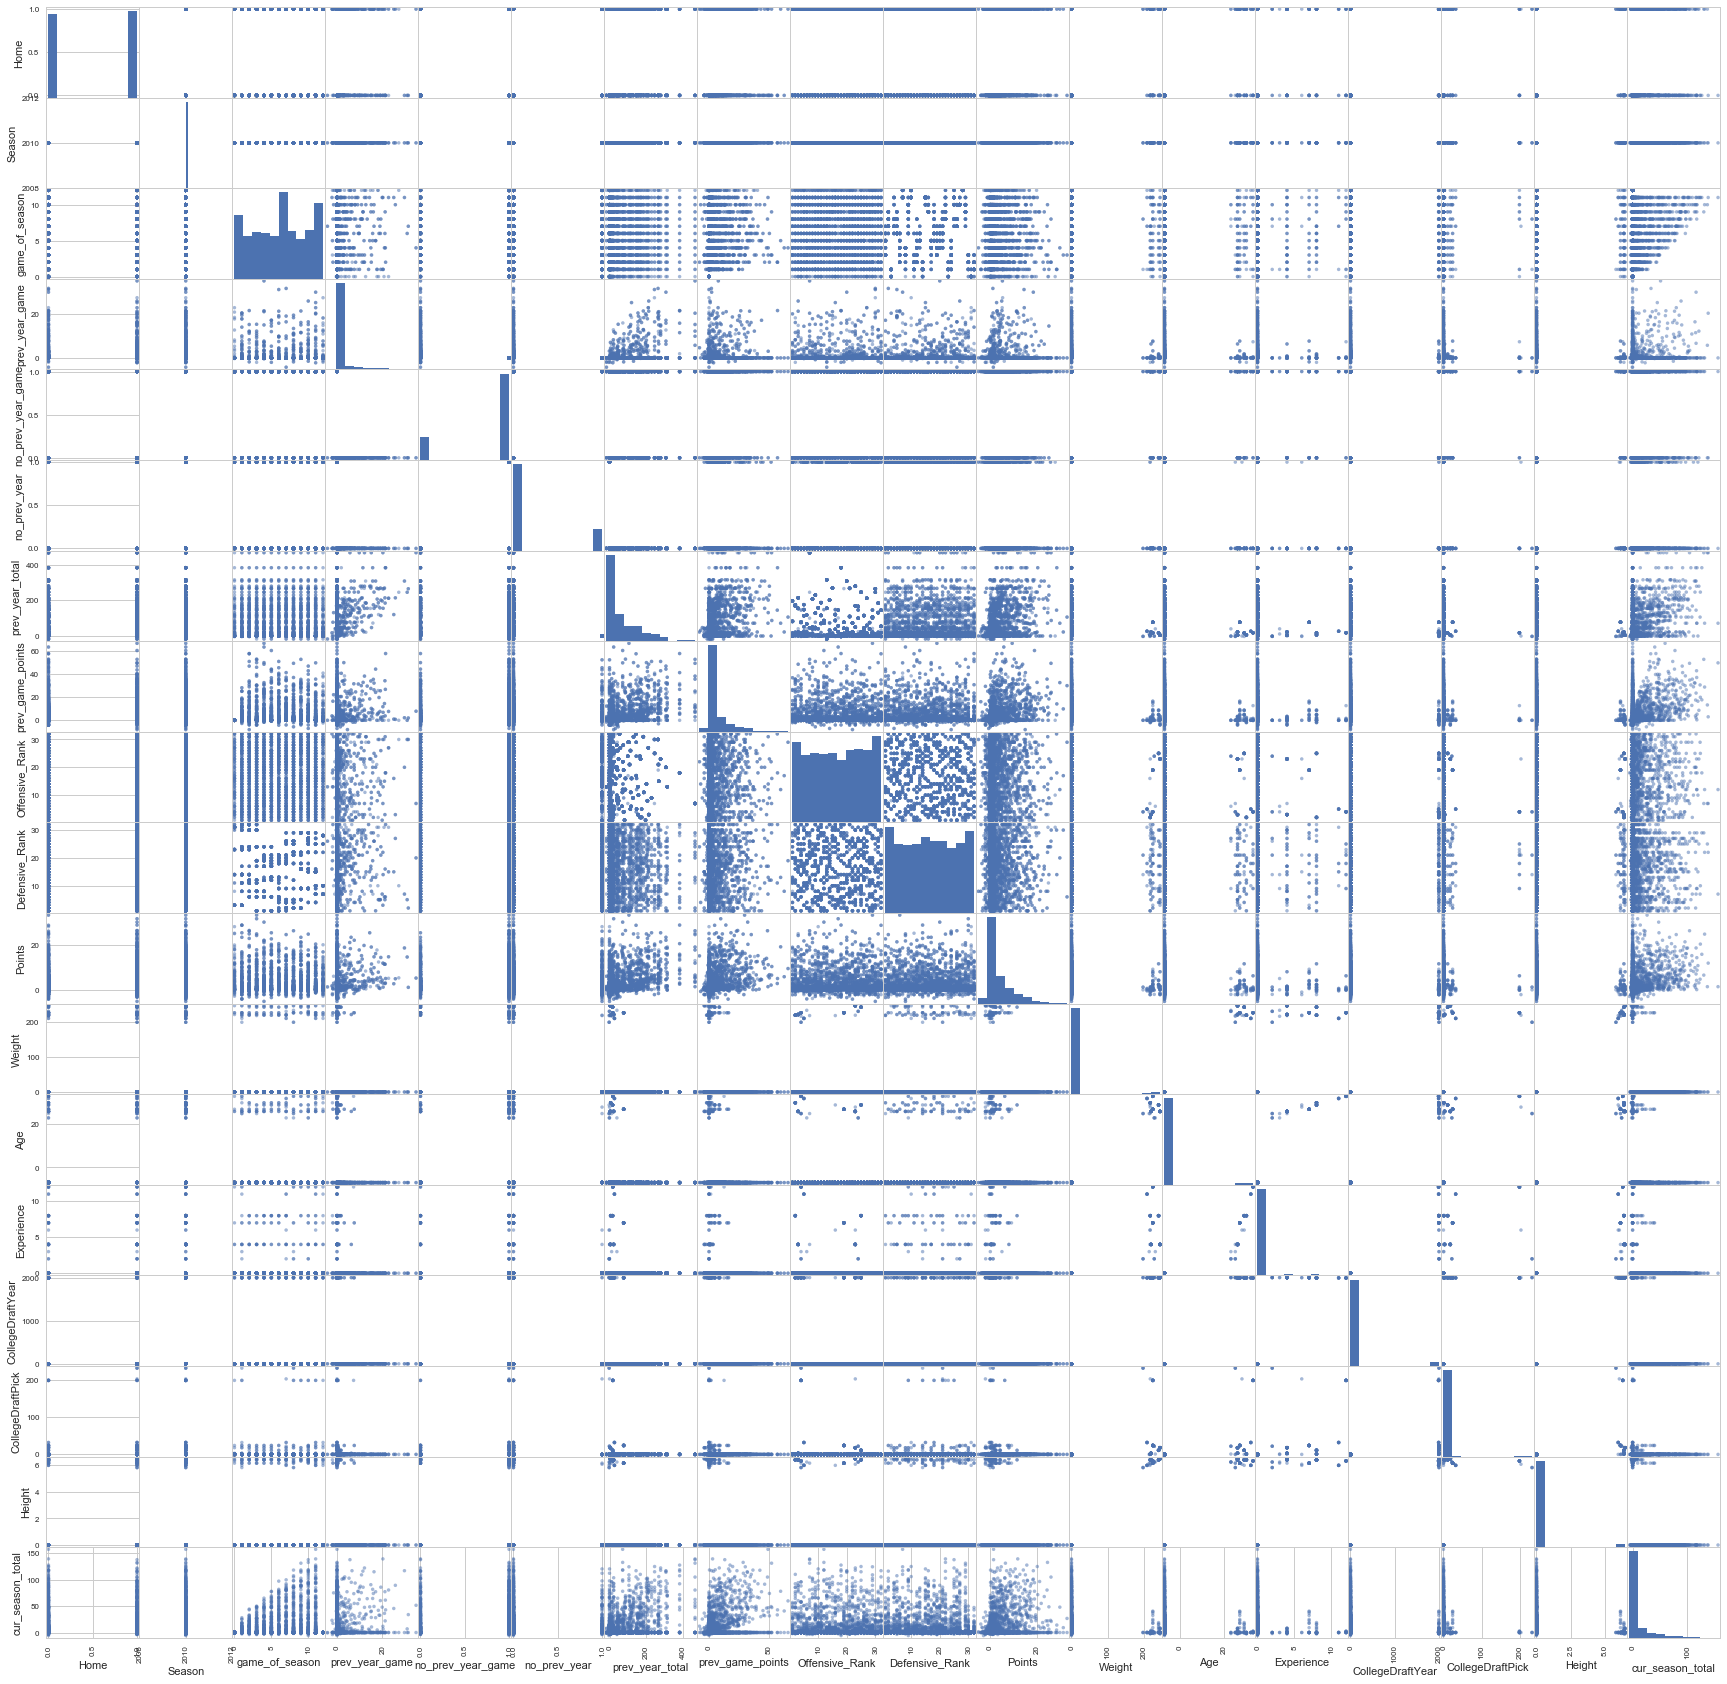

In [135]:
pd.plotting.scatter_matrix(year_2010, figsize=(30,30));

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2017.0, right=2017.0
  'left=%s, right=%s') % (left, right))
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=2017.0, top=2017.0
  'bottom=%s, top=%s') % (bottom, top))


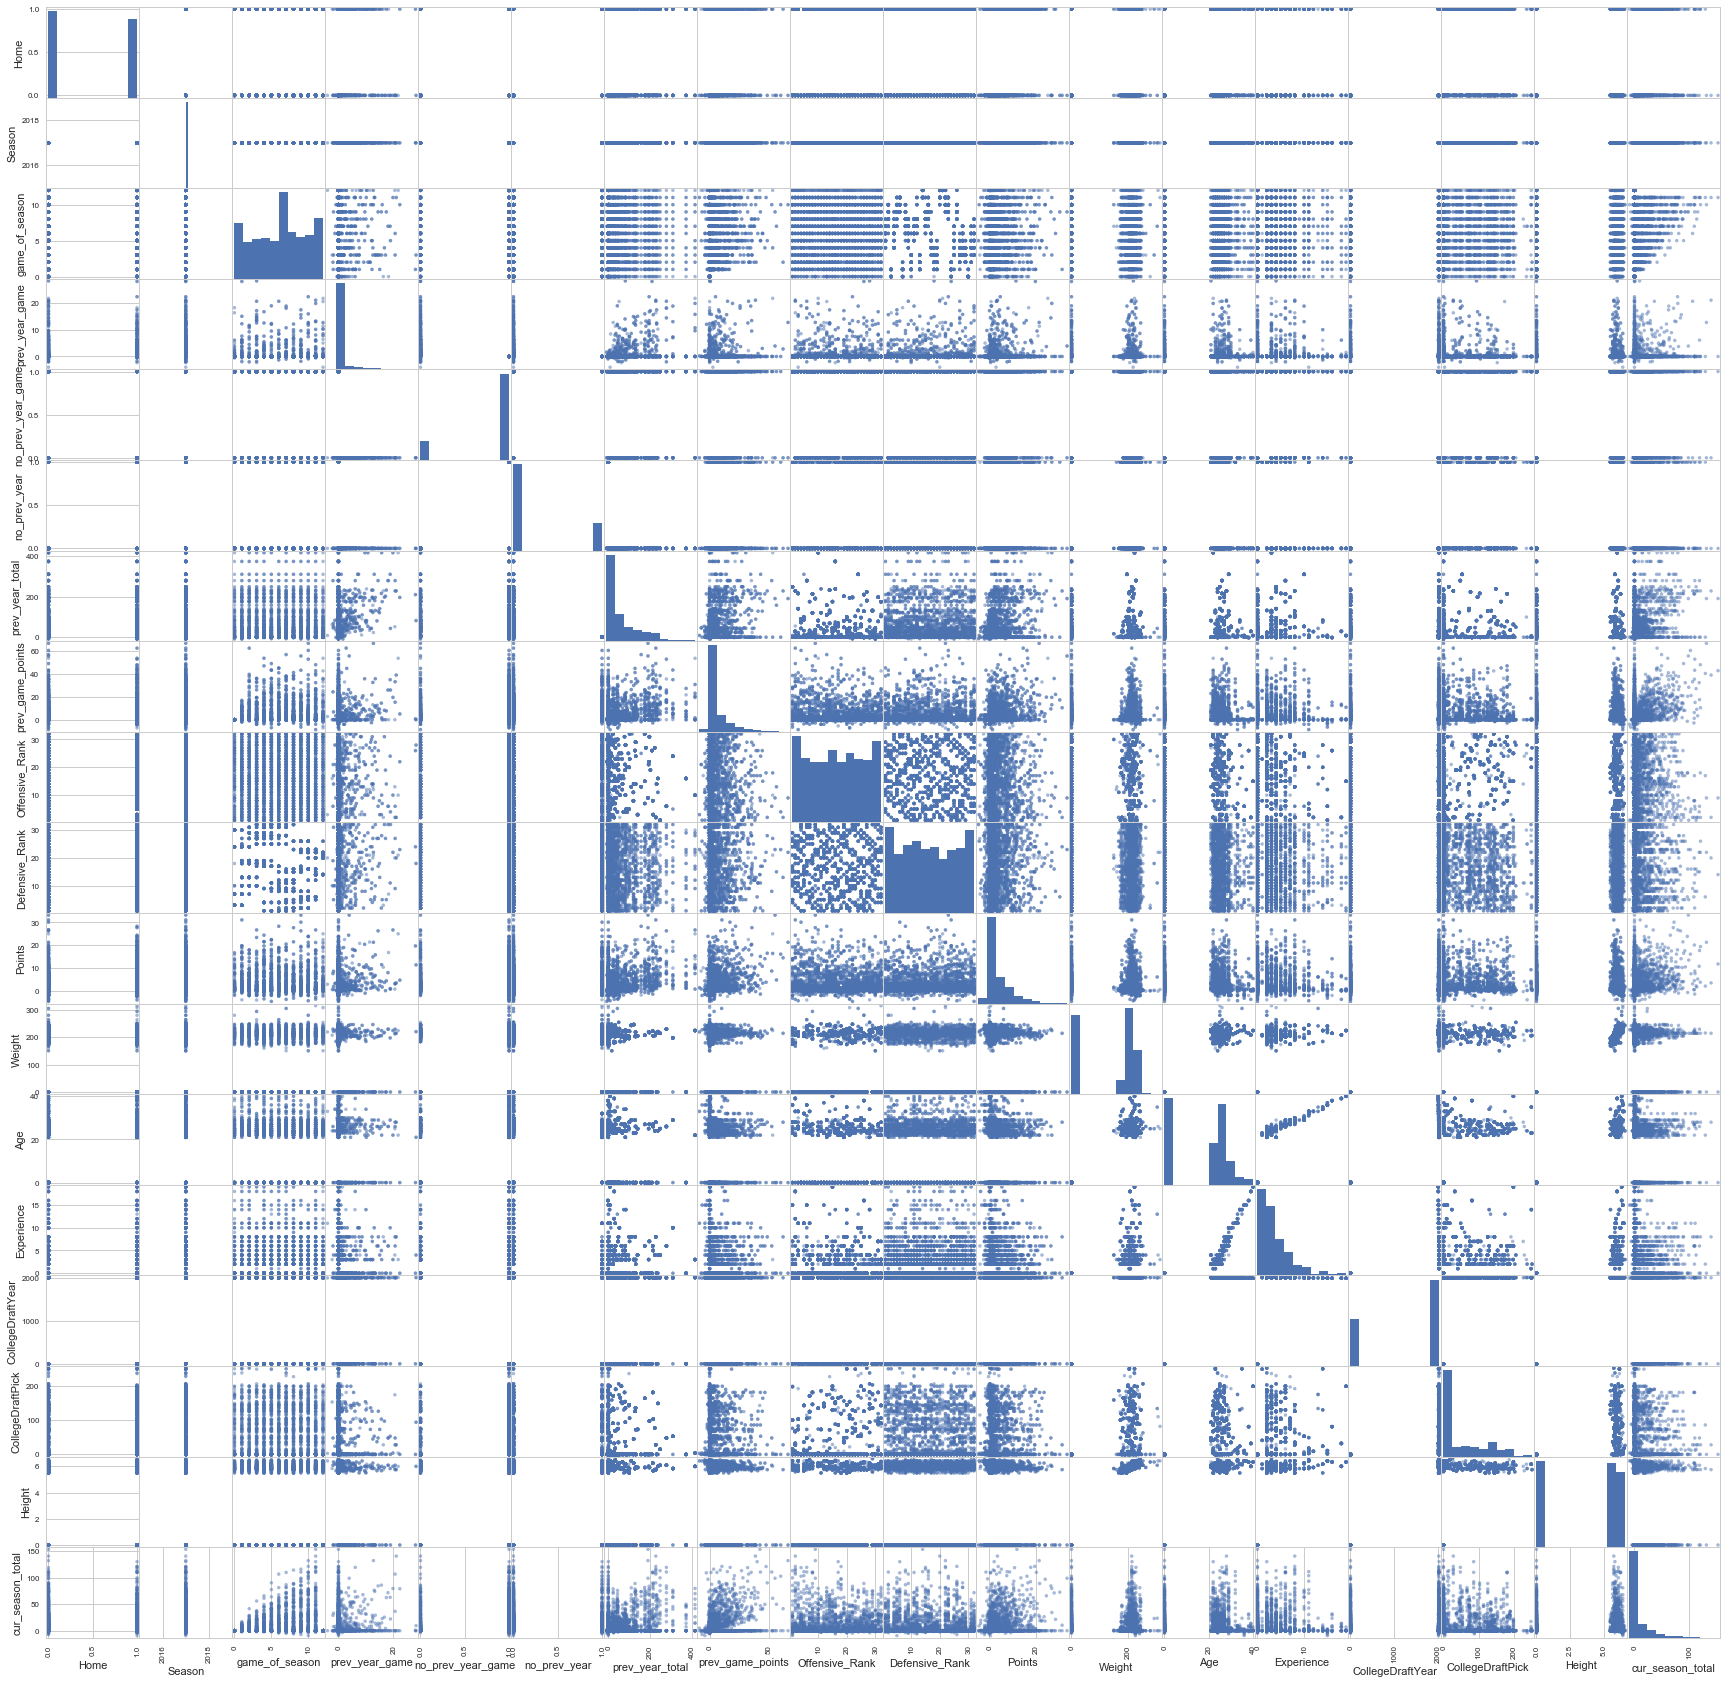

In [138]:
pd.plotting.scatter_matrix(year_2017, figsize=(30,30));